In [ ]:
import mne 
import numpy as np
import os 
import pandas as pd
import pprint
import re 
import matplotlib.pyplot as plt
import pickle
import mne
import numpy as np
import submitit
from mne.stats import permutation_cluster_test

In [8]:
pid = 'b114e7e0-92b3-43bb-9529-53860e52606d'

TF_dir = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}'
Power_files = [f for f in os.listdir(TF_dir) if f.startswith('powerLF')][0]

power = mne.time_frequency.read_tfrs(os.path.join(TF_dir, Power_files))
meta = power.metadata.reset_index()
bad_trials = meta.index[(meta['max_power'] > 500)].tolist()
high_contrast_index =meta.index[(meta['contrastLeft'] ==1) | (meta['contrastRight'] ==1)].tolist()
high_contrast_index_clean = [index for index in high_contrast_index if index not in bad_trials]
low_contrast_index =meta.index[(meta['contrastLeft'] <0.1) | (meta['contrastRight'] <0.1)].tolist()
low_contrast_index_clean = [index for index in low_contrast_index if index not in bad_trials]

TFR_high = power[high_contrast_index_clean]
TFR_low = power[low_contrast_index_clean]


Reading /mnt/data/AdaptiveControl/IBLrawdata/TF_data/b114e7e0-92b3-43bb-9529-53860e52606d/powerLF_csd_VISp4_288.h5 ...


/tmp/ipykernel_2678734/1406179903.py:6: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/TF_data/b114e7e0-92b3-43bb-9529-53860e52606d/powerLF_csd_VISp4_288.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  power = mne.time_frequency.read_tfrs(os.path.join(TF_dir, Power_files))


Replacing existing metadata with 18 columns


In [9]:
high_data = np.log10(TFR_high.data.squeeze())
low_data = np.log10(TFR_low.data.squeeze())

high_data_av = np.mean(high_data, axis=0)
low_data_av = np.mean(low_data, axis=0)

diff_data = high_data_av - low_data_av


In [15]:
import numpy as np
from mne.stats import permutation_cluster_test
from scipy.stats import t

def cluster_permute():
    # Number of observations in each condition
    n_obs1 = len(high_data)
    n_obs2 = len(low_data)

    # Combined degrees of freedom for the t-test
    df = n_obs1 + n_obs2 - 2

    # Desired significance level (e.g., 0.05 for a 5% significance level)
    alpha = 0.05

    # Two-tailed test (if tail=0)
    threshold = t.ppf(1 - alpha / 2, df)

    # Running permutation cluster test
    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [high_data, low_data],
        out_type='mask',
        n_permutations=1000,
        threshold=threshold,
        tail=0, n_jobs=4)
    
    return F_obs, clusters, cluster_p_values, H0

executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=16, timeout_min=150, slurm_partition="CPU", cpus_per_task=6, slurm_comment='plot_evoked_rightVS_left')
job = executor.submit(cluster_permute)


In [16]:
F_obs, clusters, cluster_p_values, H0 = job.result()

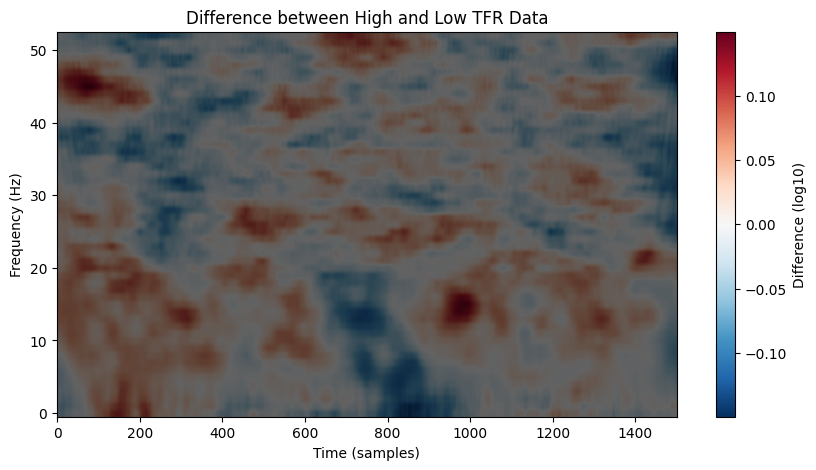

In [23]:
# Create a mask of significant clusters
significant_mask = np.zeros_like(diff_data, dtype=bool)
for i, cluster in enumerate(clusters):
    if cluster_p_values[i] < 0.05:
        significant_mask |= cluster

# Plot the difference
plt.figure(figsize=(10, 5))
plt.imshow(diff_data, aspect='auto', origin='lower', cmap='RdBu_r', vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
plt.colorbar(label='Difference (log10)')
plt.title('Difference between High and Low TFR Data')
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

# Apply shading to non-significant areas
non_significant_mask = ~significant_mask
plt.imshow(np.ma.masked_where(non_significant_mask == False, non_significant_mask), aspect='auto', origin='lower', cmap='gray', alpha=0.6)

plt.show()

In [26]:
import numpy as np
from mne.stats import permutation_cluster_test
from scipy.stats import t

def cluster_permute():
    # Running permutation cluster test
    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [high_data, low_data],
        out_type='mask',
        n_permutations=1000,
        tail=0, n_jobs=4)
    
    return F_obs, clusters, cluster_p_values, H0

executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=16, timeout_min=150, slurm_partition="CPU", cpus_per_task=6, slurm_comment='plot_evoked_rightVS_left')
job = executor.submit(cluster_permute)


In [27]:
F_obs, clusters, cluster_p_values, H0 = job.result()

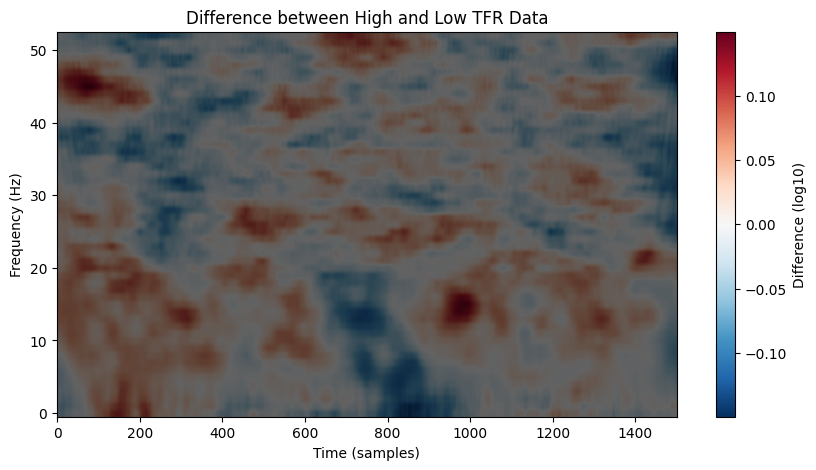

In [28]:
# Create a mask of significant clusters
significant_mask = np.zeros_like(diff_data, dtype=bool)
for i, cluster in enumerate(clusters):
    if cluster_p_values[i] < 0.05:
        significant_mask |= cluster

# Plot the difference
plt.figure(figsize=(10, 5))
plt.imshow(diff_data, aspect='auto', origin='lower', cmap='RdBu_r', vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
plt.colorbar(label='Difference (log10)')
plt.title('Difference between High and Low TFR Data')
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (Hz)')

# Apply shading to non-significant areas
non_significant_mask = ~significant_mask
plt.imshow(np.ma.masked_where(non_significant_mask == False, non_significant_mask), aspect='auto', origin='lower', cmap='gray', alpha=0.6)

plt.show()

In [13]:
pid = 'b114e7e0-92b3-43bb-9529-53860e52606d'

def plot_stimNOstim_permut(pid, version = 'csd', n_permutations = 500):
    TF_dir = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}'
    Power_files = [f for f in os.listdir(TF_dir) if f.startswith(f'powerLF_{version}')]
    path_dir = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/stimVSnoStim.ipynb/permutation_cluster_test/{pid}'
    os.makedirs(path_dir, exist_ok=True)
    for file in Power_files:   
        power = mne.time_frequency.read_tfrs(os.path.join(TF_dir, file))
        channel = power.info['ch_names'][0]
        channel = channel.replace('/', '&')
        meta = power.metadata.reset_index()
        bad_trials = meta.index[(meta['max_power'] > 500)].tolist()
        high_contrast_index =meta.index[(meta['contrastLeft'] ==1) | (meta['contrastRight'] ==1)].tolist()
        high_contrast_index_clean = [index for index in high_contrast_index if index not in bad_trials]
        low_contrast_index =meta.index[(meta['contrastLeft'] <0.1) | (meta['contrastRight'] <0.1)].tolist()
        low_contrast_index_clean = [index for index in low_contrast_index if index not in bad_trials]

        TFR_high = power[high_contrast_index_clean]
        TFR_low = power[low_contrast_index_clean]
        high_data = np.log10(TFR_high.data.squeeze())
        low_data = np.log10(TFR_low.data.squeeze())

        high_data_av = np.mean(high_data, axis=0)
        low_data_av = np.mean(low_data, axis=0)

        diff_data = high_data_av - low_data_av
        F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [high_data, low_data],
        out_type='mask',
        n_permutations= n_permutations,
        tail=0, n_jobs=3)
        # Create a mask of significant clusters
        significant_mask = np.zeros_like(diff_data, dtype=bool)
        for i, cluster in enumerate(clusters):
            if cluster_p_values[i] < 0.05:
                significant_mask |= cluster

        
        # Calculate time and frequency edges
        time_edges = np.concatenate(([TFR_low.times[0] - (TFR_low.times[1] - TFR_low.times[0]) / 2],
                                     (TFR_low.times[:-1] + TFR_low.times[1:]) / 2,
                                     [TFR_low.times[-1] + (TFR_low.times[-1] - TFR_low.times[-2]) / 2]))
        freq_edges = np.concatenate(([TFR_low.freqs[0] - (TFR_low.freqs[1] - TFR_low.freqs[0]) / 2],
                                     (TFR_low.freqs[:-1] + TFR_low.freqs[1:]) / 2,
                                     [TFR_low.freqs[-1] + (TFR_low.freqs[-1] - TFR_low.freqs[-2]) / 2]))

        # Plot the difference
        plt.figure(figsize=(10, 5))
        plt.pcolormesh(time_edges, freq_edges, diff_data, cmap='RdBu_r',
                       vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
        plt.colorbar(label='Difference (log10)')
        plt.title(f'Stim - NoStim {channel} {version}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Frequency (Hz)')

        # Apply shading to non-significant areas
        non_significant_mask = ~significant_mask
        plt.pcolormesh(time_edges, freq_edges, np.ma.masked_where(non_significant_mask == False, non_significant_mask),
                       cmap='gray', alpha=0.6)
        path_save = os.path.join(path_dir, f'{channel}_{version}.png')
        plt.savefig(path_save)
        plt.close()



In [6]:
executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=16, timeout_min=150, slurm_partition="CPU", cpus_per_task=4, slurm_comment='plot_evoked_rightVS_left')
job = executor.submit(plot_stimNOstim_permut, pid)

In [14]:
job.cancel()

## raw 

In [1]:
pid = 'b114e7e0-92b3-43bb-9529-53860e52606d'
def plot_stimNOstim_permut(pid, version = 'raw', n_permutations = 500):
    TF_dir = f'/mnt/data/AdaptiveControl/IBLrawdata/TF_data/{pid}'
    Power_files = [f for f in os.listdir(TF_dir) if f.startswith(f'powerLF_{version}')]
    path_dir = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/stimVSnoStim.ipynb/permutation_cluster_test/{pid}'
    os.makedirs(path_dir, exist_ok=True)
    for file in Power_files:   
        power = mne.time_frequency.read_tfrs(os.path.join(TF_dir, file))
        channel = power.info['ch_names'][0]
        channel = channel.replace('/', '&')
        meta = power.metadata.reset_index()
        bad_trials = meta.index[(meta['max_power'] > 500)].tolist()
        high_contrast_index =meta.index[(meta['contrastLeft'] ==1) | (meta['contrastRight'] ==1)].tolist()
        high_contrast_index_clean = [index for index in high_contrast_index if index not in bad_trials]
        low_contrast_index =meta.index[(meta['contrastLeft'] <0.1) | (meta['contrastRight'] <0.1)].tolist()
        low_contrast_index_clean = [index for index in low_contrast_index if index not in bad_trials]

        TFR_high = power[high_contrast_index_clean]
        TFR_low = power[low_contrast_index_clean]
        high_data = np.log10(TFR_high.data.squeeze())
        low_data = np.log10(TFR_low.data.squeeze())

        high_data_av = np.mean(high_data, axis=0)
        low_data_av = np.mean(low_data, axis=0)

        diff_data = high_data_av - low_data_av
        F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [high_data, low_data],
        out_type='mask',
        n_permutations= n_permutations,
        tail=0, n_jobs=3)
        # Create a mask of significant clusters
        significant_mask = np.zeros_like(diff_data, dtype=bool)
        for i, cluster in enumerate(clusters):
            if cluster_p_values[i] < 0.05:
                significant_mask |= cluster

        # save the results as dictionary
        results = {'F_obs': F_obs, 'clusters': clusters, 'cluster_p_values': cluster_p_values, 'H0': H0}
        path_save = os.path.join(path_dir, f'{channel}_{version}.pkl')
        with open(path_save, 'wb') as f:
            pickle.dump(results, f)
        print(f'{channel} {version} done')
        # Calculate time and frequency edges
        time_edges = np.concatenate(([TFR_low.times[0] - (TFR_low.times[1] - TFR_low.times[0]) / 2],
                                     (TFR_low.times[:-1] + TFR_low.times[1:]) / 2,
                                     [TFR_low.times[-1] + (TFR_low.times[-1] - TFR_low.times[-2]) / 2]))
        freq_edges = np.concatenate(([TFR_low.freqs[0] - (TFR_low.freqs[1] - TFR_low.freqs[0]) / 2],
                                     (TFR_low.freqs[:-1] + TFR_low.freqs[1:]) / 2,
                                     [TFR_low.freqs[-1] + (TFR_low.freqs[-1] - TFR_low.freqs[-2]) / 2]))

        # Plot the difference
        plt.figure(figsize=(10, 5))
        plt.pcolormesh(time_edges, freq_edges, diff_data, cmap='RdBu_r',
                       vmin=-np.max(np.abs(diff_data)), vmax=np.max(np.abs(diff_data)))
        plt.colorbar(label='Difference (log10)')
        plt.title(f'Stim - NoStim {channel} {version}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Frequency (Hz)')

        # Apply shading to non-significant areas
        non_significant_mask = ~significant_mask
        plt.pcolormesh(time_edges, freq_edges, np.ma.masked_where(non_significant_mask == False, non_significant_mask),
                       cmap='gray', alpha=0.6)
        path_save = os.path.join(path_dir, f'{channel}_{version}.png')
        plt.savefig(path_save)
        plt.close()



In [3]:
executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=16, timeout_min=150, slurm_partition="CPU", cpus_per_task=3, slurm_comment='permutation_cluster_test')
job = executor.submit(plot_stimNOstim_permut, pid)

In [4]:
job.cancel()